# Basics of Mobile Robotics

## Table of Contents

* [Introduction](#chapter1)
    * [Framework](#section_1_1)
    * [Environment](#section_1_2)
    * [Modules](#section_1_3)
    * [Librairies](#section_1_4)

* [Computer Vision](#chapter2)
    * [Vision initialization and calibration](#section_2_1)
    * [Prepocessing](#section_2_1)
    * [Map initialization](Section_2_2)
        * [Obstacles Detection](#section_2_2_1)
        * [Goal Detection](#section_2_2_2)
        * [Thymio Detection](#section_2_2_3)
    * [Resize](Section_2_3)
* [Global Navigation](#chapter3)
    * [Occupancy Grid](#section_3_1)
    * [A* Algorithm](#section_3_2)
    
* [Kalman Filter](#chapter4)
    * [Prediction](#section_4_1)
    * [Update](#section_4_2)
   
* [Local Navigation](#chapter5)
    * [Local Avoidance](#section_5_1)
    * [Kidnapping](#section_5_2)
    
* [Overall Project](#chapter6)
    * [Overview](#section_6_1)
    
* [Conclusion](#chapter7)
* [Sources](#chapter8)

## 1. Introduction <a class="anchor" id="chapter1"></a>



### 1.1 Framework  <a class="anchor" id="section_1_1"></a>
First of all, we decided to make a framwork prior to start coding. We thought it would help us to manage better the project wuth the big picture, to have a better understanding of what needs to be done and take as early as possible smart decisions. For filtering we decided to use a Kalman filter who would filter the robot position and angle detected form vision. To improve it, whe decided to add the odometry of the motors to its input. At this stage, we had in mind to compensate for vision defect with odometry, which ends up being very succesful. The, we decided to make a grid base map. We thought it would be easy and convinient since the images from the camera are already in a grid based fashion with the pixels. It led us to use the A* algortihm for the path planning, which is easy to use, with good and accesible off-the-self ressources. The rest of the framework was then straightforward. 

![frame](framework.jpg)


### 1.2 Environment <a class="anchor" id="section_1_2"></a>

![frame](env.jpg)

### 1.3 Modules <a class="anchor" id="section_1_3"></a>

describe modules 

### 1.4 Librairies <a class="anchor" id="section_1_4"></a>



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import colors
%matplotlib inline 
import VisionClass
import math
import heapq

image = cv2.imread('finalMap.png') 

## 2. Computer Vision <a class="anchor" id="chapter2"></a>

### 2.1 Preprocessing and calibration <a class="anchor" id="section_2_1"></a>

First, we filter the image taken by the camera to reduce noise in order to have a good image to analyze:

We use two filters : 
* Filter 1: a blur filter to prevent from detecting unsignificant features of the image using edge detection.
* Filter 2: a bilateral filter to preserve edges while smoothing the image.

Then we apply a threshold to work with a binary map which is more easy to analyze.

We have an image in BGR format so we need to pay attention to convert it in RGB when needed. 

This gives us the preproccessed image.


ERODE ET DILATE!!!!!!!! à cet endroit la ? 


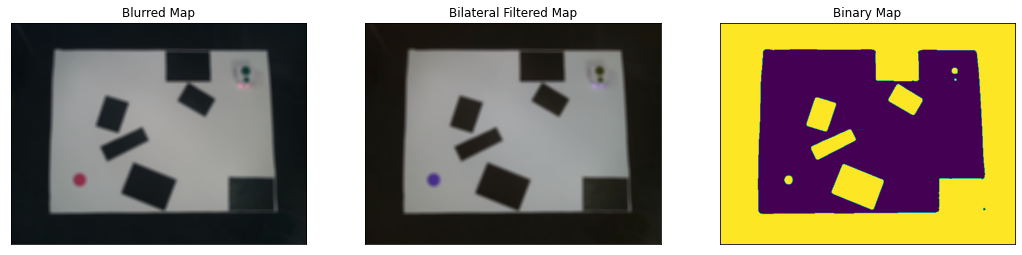

In [2]:
map_rgb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
map_blur=cv2.blur(map_rgb,(10,10))
map_rgb=cv2.cvtColor(map_blur, cv2.COLOR_BGR2RGB)
map_bilateral=cv2.bilateralFilter(map_rgb,5,15,15)
map_gray=cv2.cvtColor(map_bilateral, cv2.COLOR_RGB2GRAY)
_, map_binary=cv2.threshold(map_gray, 70, 255, cv2.THRESH_BINARY_INV)
mask=map_binary

plt.figure(figsize=(18,18))

plt.subplot(1,3,1),plt.imshow(map_blur)
plt.title("Blurred Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,2),plt.imshow(map_bilateral)
plt.title("Bilateral Filtered Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,3),plt.imshow(map_binary)
plt.title("Binary Map")
plt.xticks([]),plt.yticks([])
plt.show()

We will detect the robot, goal by filtering a specific color out of an image with an HSV filer. 
For that, we manually calibrate the values of the HSV filter for goal and robot detection, as well as a threshold value to detect obstacles by using the keyboard. This allow us to adapt the values of the filters according to the environnment which is a robust way to detect objects with different lighting conditions. 

This gives us the calibrated image. 

In practice, this is the first thing we do when we open the webcam.

### 2.2 Map initialisation

We initialise our map in three steps:
* Robot detection
* Goal detection
* Obstacles detection

#### 2.2.1 Robot detection

For this part, we use the preprocessed image and the calibration values detected manually previously. (here we set values ourselves for the report). ON LE FERA NOUS MEME AVEC LES VAL TROUVÉES AU MOMENT DE PRENDRE LA PHOTO, ET FAIRE UN RETOUR VERS AVANT

In order to detect the robot, we use :
* We change our colour space from BGR to HSV to detect green (the color of the robot) thanks to the inRange function to which we give a minimum and a maximum colour (which we detected manually previously) as well as an image. This function return a mask to extract the color we want to detect. 
* Circles detection : we must detect the two circles of the robot to know the position and set the direction of the robot
In order to do that we find all the contours in the image using an openCV function and we select the contours big enough to correspond to the circles of the robot. (and to ensure we do not consider noise as a circle) 
* Finally, we compute the position and the direction of the robot thanks to the values found for the position of the two circles 

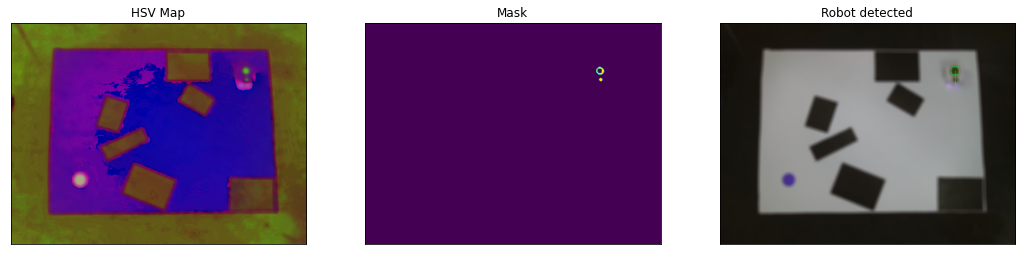

In [3]:
#we choose the values corresponding to the green (color of our robot) 
lowRobot=np.array([75, 60, 60])
highRobot=np.array([95,255,255])

map_robot = map_bilateral.copy()

filter=cv2.blur(map_robot, (3, 3)) #déjà utilisé avant? 

# Convert image to HSV
map_hsv = cv2.cvtColor(filter, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(map_hsv, lowRobot, highRobot)
# map_mask = cv2.bitwise_and(map_hsv, map_hsv, mask=mask) ON FAISAIT CA NOUS C REMPLACE PAR QUOI???? 

#circles detection
points=[]
elements=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
elements=sorted(elements, key=lambda x:cv2.contourArea(x), reverse=True)
surface = 30

for element in elements:
    if cv2.contourArea(element)>surface:
        ((x, y), rayon)=cv2.minEnclosingCircle(element)
        points.append(np.array([int(x), int(y)]))

if (len(points)>1):
    #computation of the position and direction of the robot 
    cv2.circle(filter, (points[0][0], points[0][1]), 10, (0, 255, 0), 1)
    direction=[points[1][0]-points[0][0],points[1][1]-points[0][1]]
    theta = np.arctan2(direction[1], direction[0])%(2*np.pi)
    cv2.arrowedLine(filter,(points[0][0], points[0][1]),(int(points[0][0]+30*np.cos(theta)),
            int(points[0][1]+30*np.sin(theta))),color=(0, 255, 0),thickness=1, tipLength=0.2)
    
    
robot_pos = [points[0][0], points[0][1], theta]

#plots of the map converted in HSV, the mask used to detect green and the position and direction of the robot
plt.figure(figsize=(18,18))

plt.subplot(1,3,1),plt.imshow(map_hsv)
plt.title("HSV Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,2),plt.imshow(mask)
plt.title("Mask")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,3),plt.imshow(filter)
plt.title("Robot detected")
plt.xticks([]),plt.yticks([])
plt.show()

#### 2.2.2 Goal detection

Here we detect the goal using the same process as above for the robot. That is to say, we use a HSV mask (we change the minimum and the maximum values corresponding to the red color of the HSV colorspace). 
Then we detect the contour of the red circle with the same openCV function as above.



(([], []), ([], []))

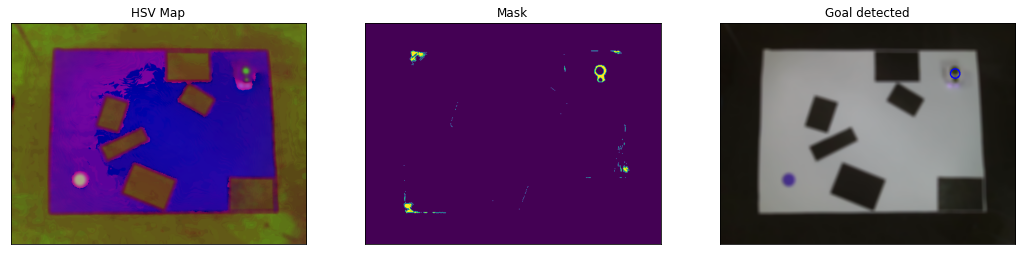

In [4]:
lowGoal=np.array([37, 14, 90])
highGoal=np.array([97, 74, 150])

map_goal = map_bilateral.copy()

filter=cv2.blur(map_goal, (3, 3))

# Convert image to HSV
map_hsv=cv2.cvtColor(filter, cv2.COLOR_BGR2HSV)
mask=cv2.inRange(map_hsv, lowGoal, highGoal)

points=[]
elements=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
elements=sorted(elements, key=lambda x:cv2.contourArea(x), reverse=True)
surface = 15
for element in elements:
    if cv2.contourArea(element)>surface:
        ((x, y), rayon)=cv2.minEnclosingCircle(element)
        points.append(np.array([int(x), int(y)]))
if (len(points)>0):
    cv2.circle(filter, (points[0][0], points[0][1]), 10, (0, 0, 255), 2)
    

goal_pos = [points[0][0], points[0][1]]

#plots of the map converted in HSV, the mask used to detect green and the position and direction of the robot
plt.figure(figsize=(18,18))

plt.subplot(1,3,1),plt.imshow(map_hsv)
plt.title("HSV Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,2),plt.imshow(mask)
plt.title("Mask")
plt.xticks([]),plt.yticks([])



plt.subplot(1,3,3),plt.imshow(filter)
plt.title("Goal detected")
plt.xticks([]),plt.yticks([])

#### 2.2.3 Obstacle detection

Here we use the preprocced image in order to construct an occupancy grid.

* Filters used (bilateral, blur, etc...) : ca ca sera expliqué au debut non? on prend bien la même image modifiée avec les filtres que pour trouver le robot et goal?

* We use morphological operators (dilate, erode, open, close, etc...). First, we use the opening that is erosion followed by dilatation to remove noise from the image taken and this with two different kernels (small one for the erosion and bigger one for the dilatation as shown below on the code). EST CE AUON PARLE DE ERODE DILATE DAPRES A AUOI CA SERT ???

* We go through each pixel of the binary map : if the pixel is black then the pixel is occupied ( = 1) otherwise, it is considered as free ( = 0) and the robot can pass through the case.
This gives the occupancy grid that the A* star will use to find the shortest path.

In [5]:
def preprocessing():
        # Convert to RGB
        map_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Blur Image
        map_blur = cv2.blur(map_rgb,(10,10))

        # Apply Bilateral filter
        map_bilateral = cv2.bilateralFilter(map_rgb,5,15,15)

        # Create Binary Image
        map_gray = cv2.cvtColor(map_bilateral, cv2.COLOR_RGB2GRAY)
        _, map_binary = cv2.threshold(map_gray, 50, 255, cv2.THRESH_BINARY_INV)

        # Opening to remove noise
        kernel_morph = np.ones((10,10),np.uint8)
        map_clean = cv2.morphologyEx(map_binary, cv2.MORPH_OPEN, kernel_morph)

        kernel_erode = np.ones((10,10),np.uint8) #60,60
        kernel_dilate = np.ones((70,70),np.uint8) #140,140
        map_occupancy = cv2.erode(map_clean, kernel_erode, iterations=1)
        if(expend):
            map_occupancy = cv2.dilate(map_occupancy, kernel_dilate, iterations=1)

        return map_occupancy
# Apply filters and morphological operators  
# Plot with subplot of different filters and morphological operators to get a dilated obstacle map

In [6]:
def create_empty_plot(max_width, max_height):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks_x = np.arange(0, max_width+1, 5)
    minor_ticks_x = np.arange(0, max_width+1, 1)
    major_ticks_y = np.arange(0, max_height+1, 5)
    minor_ticks_y = np.arange(0, max_height+1, 1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_height])
    ax.set_xlim([-1,max_width])
    ax.grid(True)
    
    return fig, ax

In [7]:
#Creating the grid
height = 40 # Size of the map
width = round(map_occupancy.shape[1]/map_occupancy.shape[0]*height)

fig, ax = create_empty_plot(width,height)

# Creating the occupancy grid
#np.random.seed(0) # To guarantee the same outcome on all computers
#data = np.random.rand(max_val, max_val) * 20 # Create a grid of 50 x 50 random values
#cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

occupancy_grid = np.ones((height,width))
n = round(map_occupancy.shape[0]/height)

for i in range(height):
    for j in range(width):
        result = np.sum(map_occupancy[n*i:n*(i+1),n*j:n*(j+1)])
        if result > 0 : 
            occupancy_grid[height-1-i,j] = 0
        
        

# Displaying the map
plt.imshow(occupancy_grid, cmap="gray")
plt.show()

NameError: name 'map_occupancy' is not defined

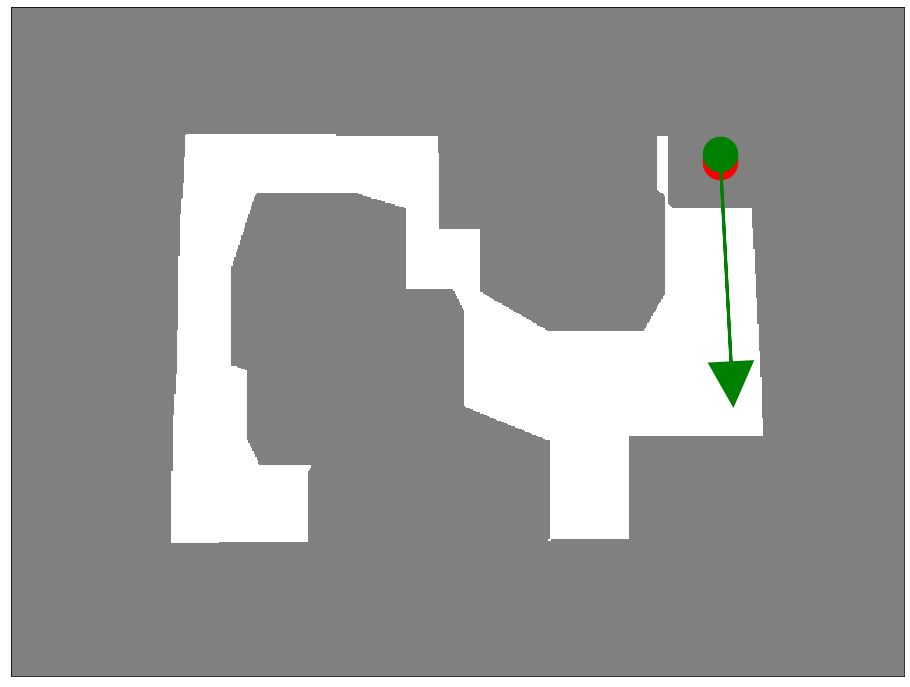

In [9]:
expend = True

cmap = colors.ListedColormap(['white', 'grey']) # Select the colors with which to display obstacles and free cells

map_occupancy=preprocessing()

width=np.size(map_occupancy,0)
height=np.size(map_occupancy,1)

occupancy_grid = np.zeros((width,height))

for i in range(width):
    for j in range(height):
        #result = np.sum(map_occupancy[i,j]) !!!!!!!!!!!!! ca sert plus à rien la sum 
        result = map_occupancy[i,j]
        if result > 0 :
            occupancy_grid[i,j] = 1


plt.figure(figsize=(16,16))
plt.imshow(occupancy_grid, cmap=cmap)
plt.scatter(goal_pos[0], goal_pos[1], marker="o", color='red', s=1200);
plt.scatter(robot_pos[0], robot_pos[1], marker="o", color='green', s=1200);


plt.arrow(robot_pos[0], robot_pos[1], 150*math.cos(robot_pos[2]),
         150*math.sin(robot_pos[2]), head_width=30, head_length=30, fc='green', ec='green', lw=3)
axes = plt.xticks([]),plt.yticks([])

# Create occupancy grid
# Plot of occupancy grid with obstacles, robot pose and goal position

### 3. Global Navigation <a class="anchor" id="chapter3"></a>

#### 3.1 Occupancy Grid<a class="anchor" id="section_3_1"></a>

#### 3.2 A* Algorithm <a class="anchor" id="section_3_2"></a>


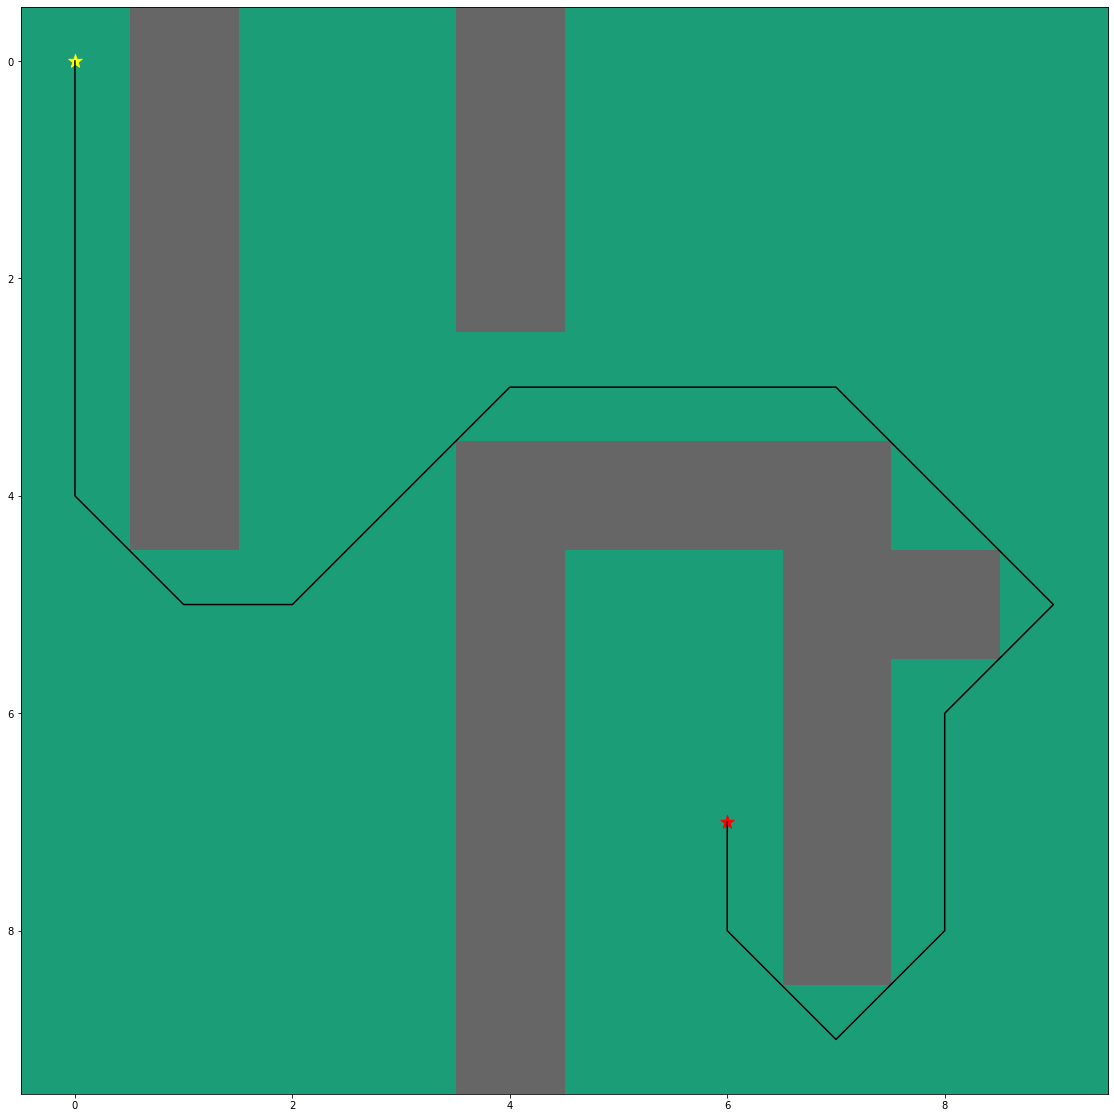

In [58]:
import ShorthestPath as sp

maze = np.array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
                 [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

start = (0, 0)
goal = (6, 7)
width = 10
height = 10

route = sp.astar(maze,height, width, start, goal)
route = route + [start]
#route = route[::-1]


# plot the path
#extract x and y coordinates from route list
x_coords = []
y_coords = []

for i in (range(0,len(route))):
    x = route[i][1]
    y = route[i][0]
    x_coords.append(x)
    y_coords.append(y)

# plot map and path
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(maze, cmap=plt.cm.Dark2)
ax.scatter(start[0],start[1], marker = "*", color = "yellow", s = 200)
ax.scatter(goal[0],goal[1], marker = "*", color = "red", s = 200)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

### 4. Kalman Filter <a class="anchor" id="chapter4"></a>
We decided at the beginning of the project to use a Kalman filter, to filter the position and orientation of the robot in the map. The  measurement came from the camera, with the vision funtion visionObject.robotDetection(). In addition we used the odometry of the robot to improve our Kalman prediction. This structure gives fairly good results, and we the camera can be blinded for the whole trajectory. 

We implemented the Kalman filter as a class. It was convenient since it needs to store the states and uncertainties. 
There is three functions in this class :
setState() for the initalisation, prediction(input, timeStep) and Update(measurement)

#### 4.1 Prediction<a class="anchor" id="section_4_1"></a>
In the prediction we update the state (robot position and angle) with its previous state and system dynamics and the input (forward speed and angular speed) and input dynamics. we update the uncertainty matrix and return the state.

#### 4.2 Update <a class="anchor" id="section_4_2"></a>
In the update we update the states and uncertainty matrix with the camera measurement and we return the updated state.


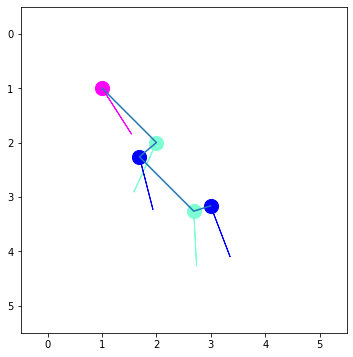

In [46]:
from KalmanFilterClass import KalmanFilterClass

#object declaration
kalmanFilter=KalmanFilterClass()

#initialisation
initialState=[1,1,1] #(x,y,théta)
kalmanFilter.setState(initialState)

#predicting
inputKalman=[1,1,1]
timeStep=1
predictedState=kalmanFilter.predict(inputKalman,timeStep)

#updating
measurement=[1.4,2.5,0.7]
updatedState=kalmanFilter.update(measurement)

#predicting 2
inputKalman=[1,1,0.2]
timeStep=1
predictedState2=kalmanFilter.predict(inputKalman,timeStep)

#updating 2
measurement=[3.2,3.1,1]
updatedState2=kalmanFilter.update(measurement)



#plotting
grid=np.zeros((6,6))
cmap = colors.ListedColormap(['white', 'grey'])
plt.figure(figsize=(6,6))
plt.imshow(grid, cmap=cmap)
plt.scatter(initialState[0], initialState[1], marker="o", color='magenta', s=200);
plt.arrow(initialState[0],initialState[1],math.cos(initialState[2]),math.sin(initialState[2]),ec='magenta')
plt.scatter(predictedState[0], predictedState[1], marker="o", color='aquamarine', s=200);
plt.arrow(predictedState[0],predictedState[1],math.cos(predictedState[2]),math.sin(predictedState[2]),ec='aquamarine')
plt.scatter(updatedState[0],updatedState[1], marker="o", color='blue', s=200);
plt.arrow(updatedState[0],updatedState[1], math.cos(updatedState[2]),math.sin(updatedState[2]),ec='blue')
plt.scatter(predictedState2[0], predictedState2[1], marker="o", color='aquamarine', s=200);
plt.arrow(predictedState2[0],predictedState2[1],math.cos(predictedState2[2]),math.sin(predictedState2[2]),ec='aquamarine')
plt.scatter(updatedState2[0],updatedState2[1], marker="o", color='blue', s=200);
plt.arrow(updatedState2[0],updatedState2[1], math.cos(updatedState2[2]),math.sin(updatedState2[2]),ec='blue')
plt.plot([initialState[0],predictedState[0],updatedState[0],predictedState2[0],updatedState2[0]],
         [initialState[1],predictedState[1],updatedState[1],predictedState2[1],updatedState2[1]])

### 5. Local Navigation <a class="anchor" id="chapter5"></a>
In the local navigation part, the `LocalNavigator.py` roles to control and run Thymio with given angle to follow the global path, avoid obstacles, and recognize a kidnapping situation.  

#### 5.1 Local Avoidance <a class="anchor" id="section_5_1"></a>
Thymio has several useful sensors to detect obstacles such as proxy sensors. The idea of the local avoidance is to consider possible cases that Thymio meets.



**1. No obstacle**
```
if any obstacles are not detected within the threshold
    FOLLOW_GLOBAL_PATH with the given angle
end

function FOLLOW_GLOBAL_PATH
    INPUT    angle
    omega <- -angle
    motor_speed <- 180 - abs(3 * omega)
    limit motor_speed into range 0 to 200
    Go forward setting as follow:
        left  motor speed <- motor_speed - omega
        right motor speed <- motor_speed + omega
end
```

**2. Front obstacle**
```
if the front middle sensor value is greater than the threshold
    if Thymio is too close to the obstacle
        Go backward
    end

    if left_sensor_val - right_sensor_val < -100    # the obstacle is close to the left side
        Turn right
    if left_sensor_val - right_sensor_val > 100     # the obstacle is close to the right side
        Turn left
    else    # parallelly
        Turn left with probability 0.05
        Turn right with probability 0.95
    end
end

```

**3. Left/Right obstacle**
```
if any of two front left sensor values is greater than the threshold
    Turn right
end

if any of two front right sensor values is greater than the threshold
    Turn left
end
```
**4. Back obstacle**
```
if any of two back sensor values is greater than the threshold
    Go forward
end
```
**5. Deadlock**
```
if Thymio continues to alternate right and left turns over 20 times
    deadlock_flag <- TRUE
else
    deadlock_flag <- FALSE
end
if deadlock_flag is TRUE
    Turn right until there is no more obstacle
end
```

To make Thymio move smoothly, we set the motor speed corresponding to the distance to obstacles. Closer obstacles are, less motor speed is set.


#### 5.2 Kidnapping <a class="anchor" id="section_5_2"></a>
The idea to detect whether Thymio is kidnapped or not is to check its proxy ground sensor (`prox.ground.reflected`) value corresponding to the distance to the ground. Closer Thymio is to the ground, greater the sensor value is.
```
if all of ground_sensor_val is less than threshold
    kidnap <- TRUE
else
    kidnap <- FALSE
end
```


 

### 6. Overall Project <a class="anchor" id="chapter6"></a>

#### 6.1 Overview <a class="anchor" id="section_6_1"></a>
#### 6.2 Main Function <a class="anchor" id="section_6_2"></a>

### 7. Conclusion<a class="anchor" id="chapter7"></a>

    




### 8. Sources <a class="anchor" id="chapter8"></a>

All sources used for the project from internet
Maybe we shouuld also talk about the session that we use from the course 




#### A* <a class="anchor" id="section_8_1"></a>
For the A* algorithm, we based ourself on the work from Andrew Jones who wrote an article on Analytics Link. His work is itself based on previous work from Christian Careaga. We made some little ajustement but the code is mostly from his work. It can be found at https://www.analytics-link.com/post/2018/09/14/applying-the-a-path-finding-algorithm-in-python-part-1-2d-square-grid .

#### Kalman Filter and Vision<a class="anchor" id="section_8_2"></a>
We used extensivly the work from L42project for our Kalman Filter and vision. He has a youtube channel with explanations of great quality and a gitHub repository where the code he uses can be found. We would like to thanks him specially for his help and ressources. We used his codes in our work.   It can be found at : 
youtube channel : https://www.youtube.com/channel/UCn09iU3hS5Fpxv0XniGv2FQ/about
GitHub repository : https://github.com/L42Project/Tutoriels